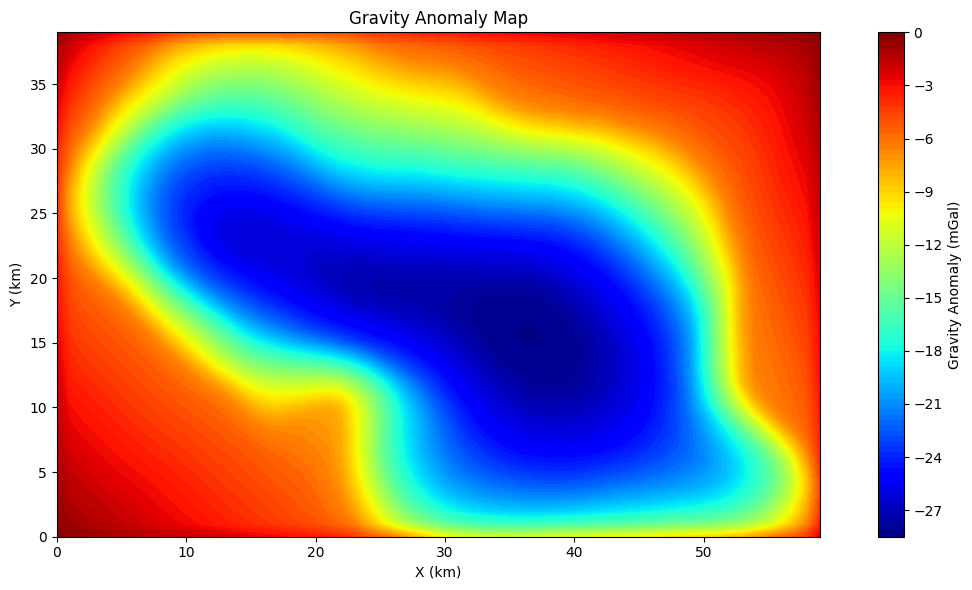

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

gz = np.loadtxt("gravity_real_santos.txt")
x = np.loadtxt("real_x_santos.txt") / 1000 
y = np.loadtxt("real_y_santos.txt") / 1000  



# Trim x and y to match the gz data shape
x_trimmed = x[:gz.shape[1]]
y_trimmed = y[:gz.shape[0]]


X_trimmed, Y_trimmed = np.meshgrid(x_trimmed, y_trimmed)

plt.figure(figsize=(12, 6))
contour = plt.contourf(X_trimmed, Y_trimmed, gz, cmap="jet", levels=100)
cbar = plt.colorbar(contour)
cbar.set_label('Gravity Anomaly (mGal)')

plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.title("Gravity Anomaly Map")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()



🔄 Running DE global search...
differential_evolution step 1: f(x)= 119.6698341302906
differential_evolution step 2: f(x)= 113.28879573509148
differential_evolution step 3: f(x)= 113.28879573509148
differential_evolution step 4: f(x)= 103.15102632041419
differential_evolution step 5: f(x)= 80.60101581330824
differential_evolution step 6: f(x)= 80.60101581330824
differential_evolution step 7: f(x)= 80.60101581330824
differential_evolution step 8: f(x)= 80.60101581330824
differential_evolution step 9: f(x)= 80.60101581330824
differential_evolution step 10: f(x)= 80.60101581330824
differential_evolution step 11: f(x)= 80.60101581330824
differential_evolution step 12: f(x)= 74.64924876574288
differential_evolution step 13: f(x)= 74.64924876574288
differential_evolution step 14: f(x)= 74.64924876574288
differential_evolution step 15: f(x)= 74.64924876574288
differential_evolution step 16: f(x)= 74.64924876574288
differential_evolution step 17: f(x)= 72.66980320938504
differential_evolution s

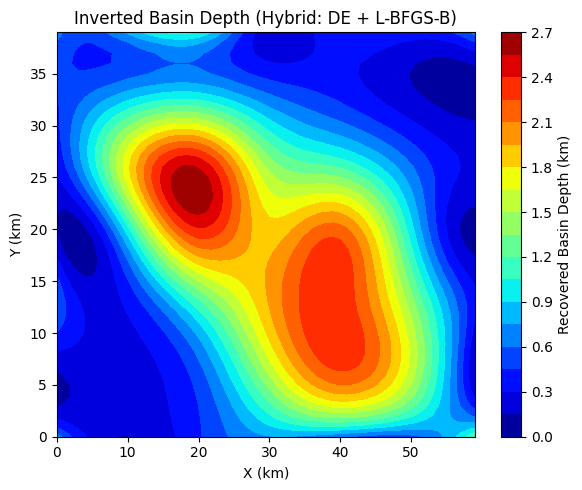

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize
from scipy.interpolate import RectBivariateSpline
from gauss_fft_general3d import gauss_fft_gravity_3d


gz_obs = np.loadtxt("gravity_real_santos.txt")[:40, :60]  # shape (40, 60)
x = np.loadtxt("real_x_santos.txt")[:60] / 1000.0  # km
y = np.loadtxt("real_y_santos.txt")[:40] / 1000.0  # km

nx, ny = len(x), len(y)
dx = dy = 1000.0  # meters

X, Y = np.meshgrid(x, y, indexing='xy')  # shape (40, 60)



max_depth = 4000  # meters
nz = 20
z_edges = np.linspace(0, max_depth, nz + 1)
zc = 0.5 * (z_edges[:-1] + z_edges[1:])
dz = z_edges[1] - z_edges[0]

def delta_rho(z_m):
    z_km = z_m / 1000.0
    raw = 1000 * (-0.125) / (-0.5 - 0.1711 * z_km)**2
    return np.clip(raw, -1000, -140)

def build_density_model(basin_surface, zc):
    rho = np.zeros((nx, ny, nz))
    for k, z in enumerate(zc):
        mask = z < basin_surface
        rho[:, :, k][mask] = delta_rho(z)
    return rho


# Control grid setup

n_ctrl_x, n_ctrl_y = 7, 7
x_ctrl = np.linspace(x.min(), x.max(), n_ctrl_x)
y_ctrl = np.linspace(y.min(), y.max(), n_ctrl_y)

def surface_from_params(params):
    ctrl_depths = params.reshape((n_ctrl_x, n_ctrl_y))
    spline = RectBivariateSpline(x_ctrl, y_ctrl, ctrl_depths, kx=3, ky=3)
    return np.clip(spline(x, y, grid=True), 0, max_depth)  # shape (60, 40)

# Misfit function

def misfit(params):
    basin_depth = surface_from_params(params)
    rho_model = build_density_model(basin_depth, zc)
    gz_pred = gauss_fft_gravity_3d(dx, dy, dz, zc, rho_model,
                                   z0=0.0, n_terms=6, nq=8)
    return np.mean((gz_pred.T - gz_obs)**2)


# Run DE (Global)

bounds = [(0, max_depth)] * (n_ctrl_x * n_ctrl_y)
print("🔄 Running DE global search...")
result_de = differential_evolution(
    misfit, bounds, strategy='best1bin',
    maxiter=130, popsize=11, tol=1e-5,
    polish=False, disp=True
)

best_de_params = result_de.x

# Run L-BFGS-B (Local)

print("🚀 Refining with L-BFGS-B...")
result_local = minimize(
    misfit, best_de_params,
    method='L-BFGS-B', bounds=bounds,
    options={'maxiter': 150, 'disp': True}
)

best_params = result_local.x


# Recovered surface and gravity

recovered_surface = surface_from_params(best_params)  # shape (60, 40)
rho_model = build_density_model(recovered_surface, zc)
gz_recovered = gauss_fft_gravity_3d(dx, dy, dz, zc, rho_model,
                                    z0=0.0, n_terms=6, nq=8).T  # shape (40, 60)


# Plot recovered basin

plt.figure(figsize=(6, 5))
cs = plt.contourf(X, Y, recovered_surface.T / 1000, levels=20, cmap='jet')
plt.colorbar(cs, label='Recovered Basin Depth (km)')
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.title("Inverted Basin Depth (Hybrid: DE + L-BFGS-B)")
plt.tight_layout()
plt.show()




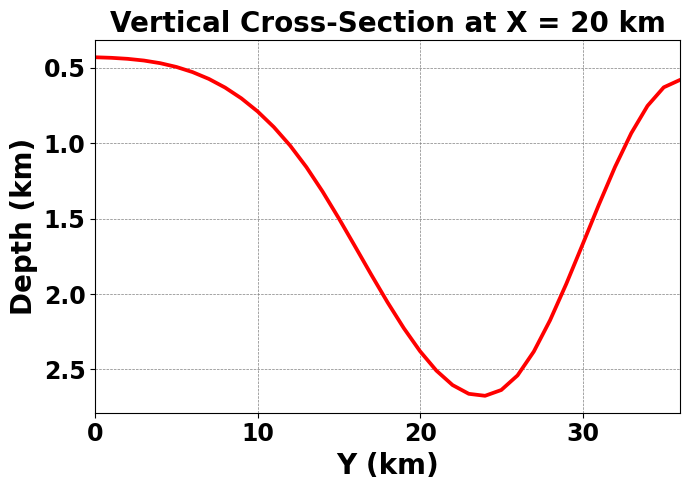

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

ix = np.argmin(np.abs(x -20)) 
section_y = recovered_surface[ix, :] / 1000.0  
y_km = y  # already in km

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(y_km, section_y, color='red', linewidth=2.7, label="Recovered Basin")

ax.set_xlabel("Y (km)", fontweight='bold', fontsize=20)
ax.set_xlim(0,36)
ax.set_ylabel("Depth (km)", fontweight='bold', fontsize=20)
ax.set_title("Vertical Cross-Section at X = 20 km", fontweight='bold', fontsize=20)


ax.tick_params(axis='both', labelsize=17)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

ax.xaxis.set_major_locator(MultipleLocator(10))      
ax.yaxis.set_major_locator(MultipleLocator(0.5))    


ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


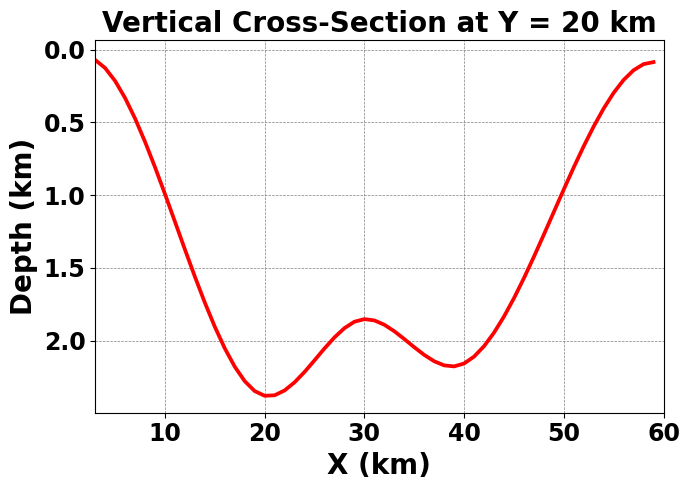

In [ ]:

iy = np.argmin(np.abs(y - 20))  
section_x = recovered_surface[:, iy] / 1000.0  
x_km = x  


fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_km, section_x, color='red', linewidth=2.7, label="Recovered Basin")

ax.set_xlabel("X (km)", fontweight='bold', fontsize=20)
ax.set_xlim(3,60)
ax.set_ylabel("Depth (km)", fontweight='bold', fontsize=20)
ax.set_title("Vertical Cross-Section at Y = 20 km", fontweight='bold', fontsize=20)


ax.tick_params(axis='both', labelsize=17)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')


ax.xaxis.set_major_locator(MultipleLocator(10))     
ax.yaxis.set_major_locator(MultipleLocator(0.5))   

# Grid and reverse Y-axis
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


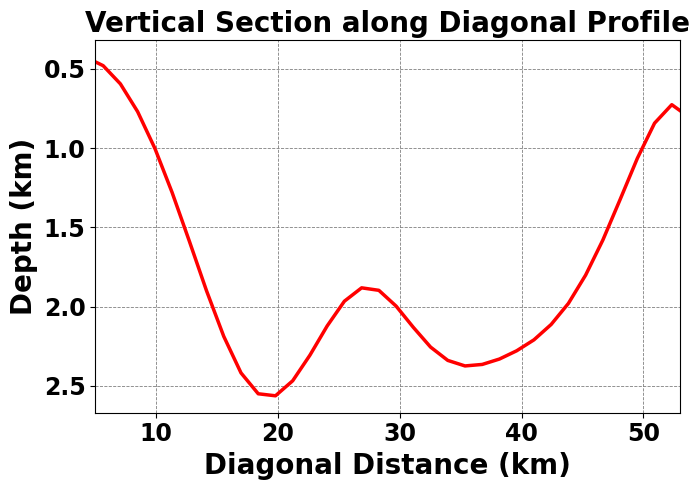

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.ndimage import map_coordinates


n_steps = min(nx, ny)
x_diag = np.linspace(0, nx - 1, n_steps)
y_diag = np.linspace(ny - 1, 0, n_steps)

coords = np.vstack([x_diag, y_diag])  
diag_depth_km = map_coordinates(recovered_surface, coords, order=1) / 1000.0  


dx_km = (x[1] - x[0])
dy_km = (y[1] - y[0])
diag_distance = np.sqrt(dx_km**2 + dy_km**2) * np.arange(n_steps)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(diag_distance, diag_depth_km, color='red', linewidth=2.5, label="Recovered Basin")

ax.set_xlabel("Diagonal Distance (km)", fontweight='bold', fontsize=20)
ax.set_xlim(5,53)
ax.set_ylabel("Depth (km)", fontweight='bold', fontsize=20)
ax.set_title("Vertical Section along Diagonal Profile", fontweight='bold', fontsize=20)

ax.tick_params(axis='both', labelsize=17)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')


ax.xaxis.set_major_locator(MultipleLocator(10))  
ax.yaxis.set_major_locator(MultipleLocator(0.5))     

# Grid + reverse Y
ax.grid(True, linestyle='--', color='gray', linewidth=0.6)
ax.invert_yaxis()


plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go


Z = recovered_surface.T 
x_km = x 
y_km = y  

fig = go.Figure(data=[go.Surface(
    z=-Z,  
    x=x_km,
    y=y_km,
    colorscale='jet',
    reversescale=True,
    showscale=True,
    colorbar=dict(title='Depth (m)')
)])

fig.update_layout(
    title="3D Recovered Basin Surface",
    scene=dict(
        xaxis_title='X [km]',
        yaxis_title='Y [km]',
        zaxis_title='Depth [m]',
        zaxis=dict() 
    ),
    margin=dict(l=0, r=0, t=30, b=0)
)

fig.show()


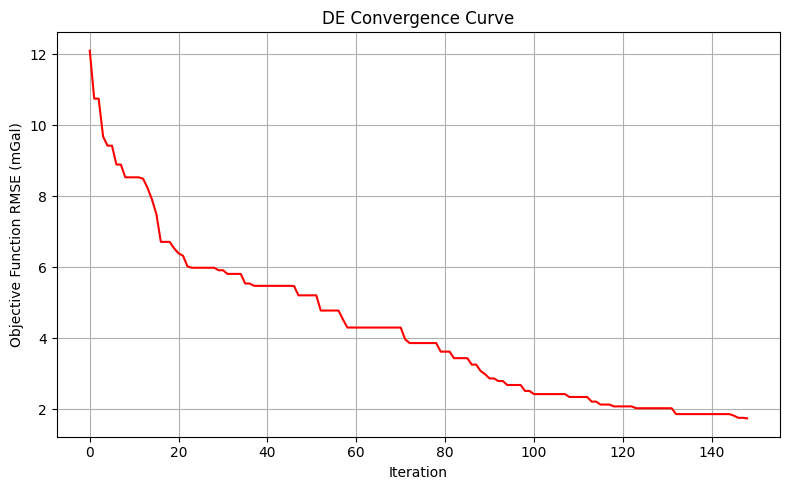

In [61]:
convergence_values = [
146.231, 115.438, 115.438, 93.665, 88.755, 88.755, 79.018, 79.018, 72.763, 72.763,
72.763, 72.763, 72.114, 67.807, 62.527, 56.168, 45.073, 45.073, 45.073, 42.645,
40.820, 39.983, 36.278, 35.825, 35.825, 35.825, 35.825, 35.825, 35.825, 34.997,
34.997, 33.787, 33.787, 33.787, 33.787, 30.714, 30.714, 29.992, 29.992, 29.992,
29.992, 29.992, 29.992, 29.992, 29.992, 29.992, 29.924, 27.140, 27.140, 27.140,
27.140, 27.140, 22.866, 22.866, 22.866, 22.866, 22.866, 20.546, 18.519, 18.519,
18.519, 18.519, 18.519, 18.519, 18.519, 18.519, 18.519, 18.519, 18.519, 18.519,
18.519, 15.793, 14.954, 14.954, 14.954, 14.954, 14.954, 14.954, 14.954, 13.146,
13.146, 13.146, 11.844, 11.844, 11.844, 11.844, 10.632, 10.632, 9.500, 8.946,
8.247, 8.247, 7.830, 7.830, 7.218, 7.218, 7.218, 7.218, 6.347, 6.347, 5.907,
5.907, 5.907, 5.907, 5.907, 5.907, 5.907, 5.907, 5.520, 5.520, 5.520, 5.520,
5.520, 4.926, 4.926, 4.564, 4.564, 4.564, 4.347, 4.347, 4.347, 4.347, 4.347,
4.134, 4.134, 4.134, 4.134, 4.134, 4.134, 4.134, 4.134, 4.134, 3.490, 3.490,
3.490, 3.490, 3.490, 3.490, 3.490, 3.490, 3.490, 3.490, 3.490, 3.490, 3.490,
3.331, 3.109, 3.109, 3.058
]
plt.figure(figsize=(8,5))
plt.plot(np.sqrt(convergence_values), color="red")
plt.xlabel("Iteration")
plt.ylabel("Objective Function RMSE (mGal)")
plt.title("DE Convergence Curve")
plt.grid()
plt.tight_layout()
plt.show()


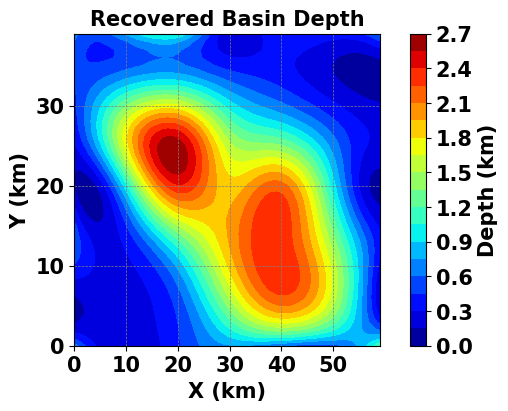

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)


cs = ax.contourf(X, Y, recovered_surface.T / 1000, levels=20, cmap='jet') 
ax.set_title("Recovered Basin Depth", fontweight='bold', fontsize=15)
ax.set_xlabel("X (km)", fontweight='bold', fontsize=15)
ax.set_ylabel("Y (km)", fontweight='bold', fontsize=15)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
ax.tick_params(axis='both', labelsize=15)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')


cbar = fig.colorbar(cs, ax=ax, orientation='vertical', fraction=0.1, pad=0.1)
cbar.set_label('Depth (km)', fontweight='bold', fontsize=15)
cbar.ax.tick_params(labelsize=15)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

plt.show()


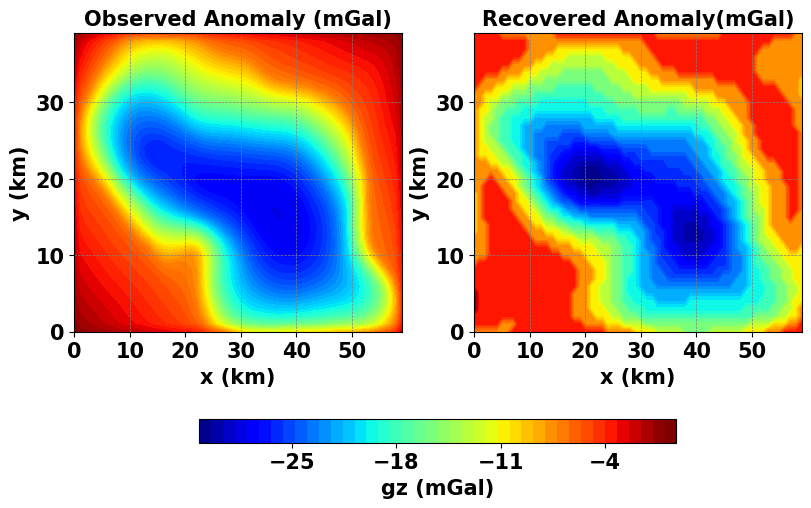

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np



x = X[0, :]   
y = Y[:, 0]   

vmin = np.min([gz_obs.min(), gz_recovered.min()])
vmax = np.max([gz_obs.max(), gz_recovered.max()])

tick_spacing_km = 10
cbar_ticks = np.arange(np.floor(vmin), np.ceil(vmax) + 1, 7)

fig, axs = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)

titles = ["Observed Anomaly (mGal)", "Recovered Anomaly(mGal)"]
data = [gz_obs, gz_recovered]

for i in range(2):
    im = axs[i].contourf(x, y, data[i], levels=50, cmap='jet', vmin=vmin, vmax=vmax)
    axs[i].set_title(titles[i], fontweight='bold', fontsize=15)
    axs[i].set_xlabel("x (km)", fontweight='bold', fontsize=15)
    axs[i].set_ylabel("y (km)", fontweight='bold', fontsize=15)
    axs[i].xaxis.set_major_locator(MultipleLocator(tick_spacing_km))
    axs[i].yaxis.set_major_locator(MultipleLocator(tick_spacing_km))
    axs[i].grid(True, linestyle='--', color='gray', linewidth=0.5)
    axs[i].tick_params(axis='both', labelsize=15)
    for label in axs[i].get_xticklabels() + axs[i].get_yticklabels():
        label.set_fontweight('bold')

cbar = fig.colorbar(im, ax=axs, orientation='horizontal',
                    fraction=0.08, pad=0.1, ticks=cbar_ticks)

cbar.set_label("gz (mGal)", fontweight='bold', fontsize=15)
cbar.ax.tick_params(labelsize=15)
for label in cbar.ax.get_xticklabels():
    label.set_fontweight('bold')

plt.show()
